### Market Madness Indicator 

In [ ]:
# %load ../Data/factors.py
import httplib
import urllib
import json
import traceback
import pandas as pd
from sqlalchemy import *


In [7]:
### read IF future 1min for 2015

def read_data() :
    df = pd.read_excel('IF1m_2015.xlsx')
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    
    df = df[['open', 'high', 'low', 'close']]
    return df

data = read_data()
data['price'] = data['close']

IOError: [Errno 2] No such file or directory: 'IF1m_2015.xlsx'

通过Quandl下载数据

In [8]:
import Quandl
df_spx = Quandl.get('GOOG/NYSE_SPY', collapse='monthly')
data = pd.DataFrame()
data['price'] = df_spx.iloc[:, 3]

import numpy as np
#data['price'] = data['close']
data['delta'] = data['price'] - data['price'].shift(1)
data['ret'] = data['price'] / data['price'].shift(1) - 1
data = data.dropna()

In [9]:
df_spx.head()

,Open,High,Low,Close,Volume
Date,,,,,
1997-08-31,0,91.11,89.72,90.38,2652300
1997-09-30,0,95.69,94.38,94.38,4137600
1997-10-31,0,92.50,90.44,92.06,7072700
1997-11-30,0,96.25,95.59,95.62,1564700
1997-12-31,0,97.62,96.69,97.06,4359500


In [4]:
def MMI(data) :
    me = np.median(data)
    length = len(data)
    nl = 0
    nh = 0
    for i in range(length-1) :
        if data[i+1] > me and data[i+1] > data[i]:
            nh = nh + 1
        if data[i+1] < me and data[i+1] < data[i]:
            nl = nl + 1
    mmi = 100.0 * (nh + nl) / (length - 1)
    return mmi

### Market Madness Index (市场疯狂指数）
通常我们可以用价格（Pt）或者价格差（Pt - Pt_1)作为MMI指数的输入。 MMI指数的原理是：如果data[i+1]>data[i]，同时data[i+1]>median（data）， 计数nh+1。如果data[i+1]<data[i]，同时data[i+1]<median(data), 计数nl+1。 
在给定窗口内， nh+nl一共发生反转（mean-reverting）的次数超过75%， 则认为该时间序列为无趋势噪音。如果低于75%， 则认为该时间序列为趋势。 

MMI从原理上与Hurst指数， Fractal Dimension分型维度类似， 都是在测量一个时间序列是否呈现一致性的趋势， 或者是无序的波动性。 


In [5]:
data['MA'] = pd.rolling_mean(data['price'], 10)

data['mmi_delta'] = pd.rolling_apply(data[['delta']], window=10, func=MMI)
data['mmi_ret'] = pd.rolling_apply(data[['ret']], window=10, func=MMI)
data['mmi'] = data['mmi_ret']

data['buy'] = (data['price'] > data['MA']) * (data['price'].shift(1) < data['MA'].shift(1))
data['sell'] = (data['price'] < data['MA']) * (data['price'].shift(1) > data['MA'].shift(1))

data['f_buy'] = data['buy'] * (data['mmi']<data['mmi'].shift(1))*(data['mmi'] < 75) * data['price']
data['f_sell'] = data['sell'] * (data['mmi']<data['mmi'].shift(1))*(data['mmi'] < 75) * data['price']
data[['price', 'MA', 'f_buy', 'f_sell', 'mmi']].plot(figsize=[30,15])

data['vol'] = pd.rolling_std(data[['ret']], window=20)

NameError: name 'data' is not defined

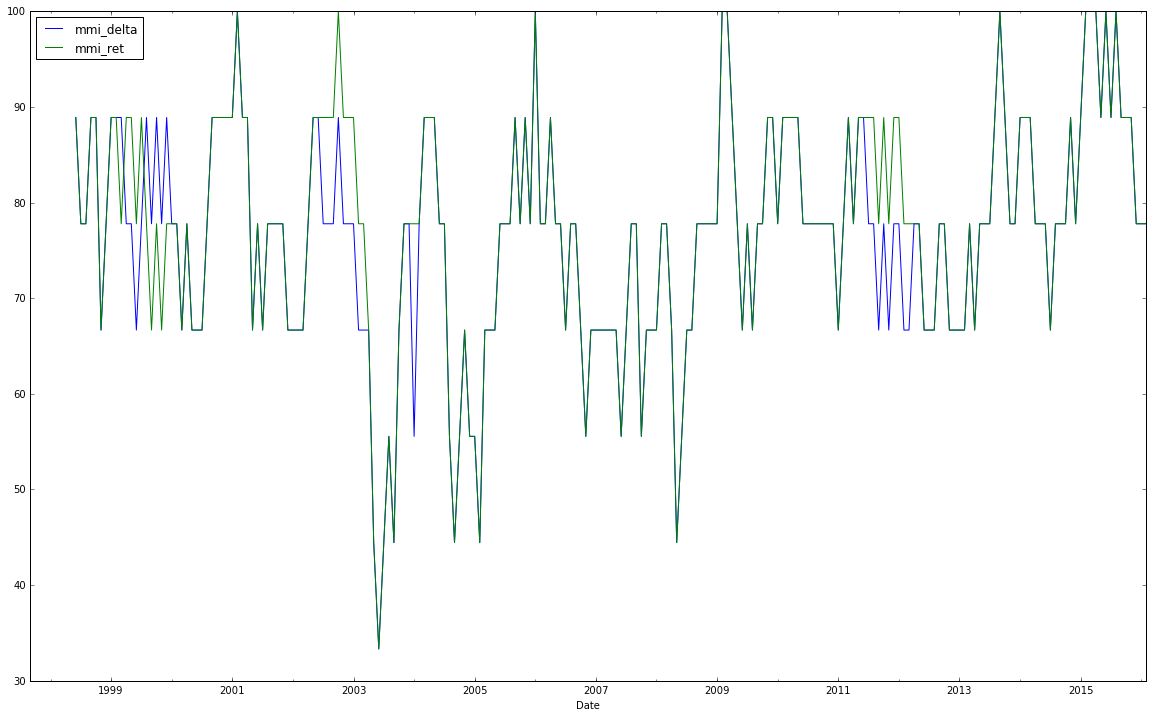

In [510]:
data[['mmi_delta', 'mmi_ret']].plot(figsize=[20,12])

In [521]:
data['pos'] = (data['price'] > data['MA'])*1 - (data['price'] < data['MA'])* 1
#data['pos'] = (data['price'] < data['MA'])* -1
data['pos_f'] = data['pos'] * ((data['mmi']< 75) | (data['mmi'] > pd.rolling_mean(data['mmi'], 5)))
data['pos_v'] = data['pos'] * (data['vol'] < pd.rolling_mean(data['vol'], 30))

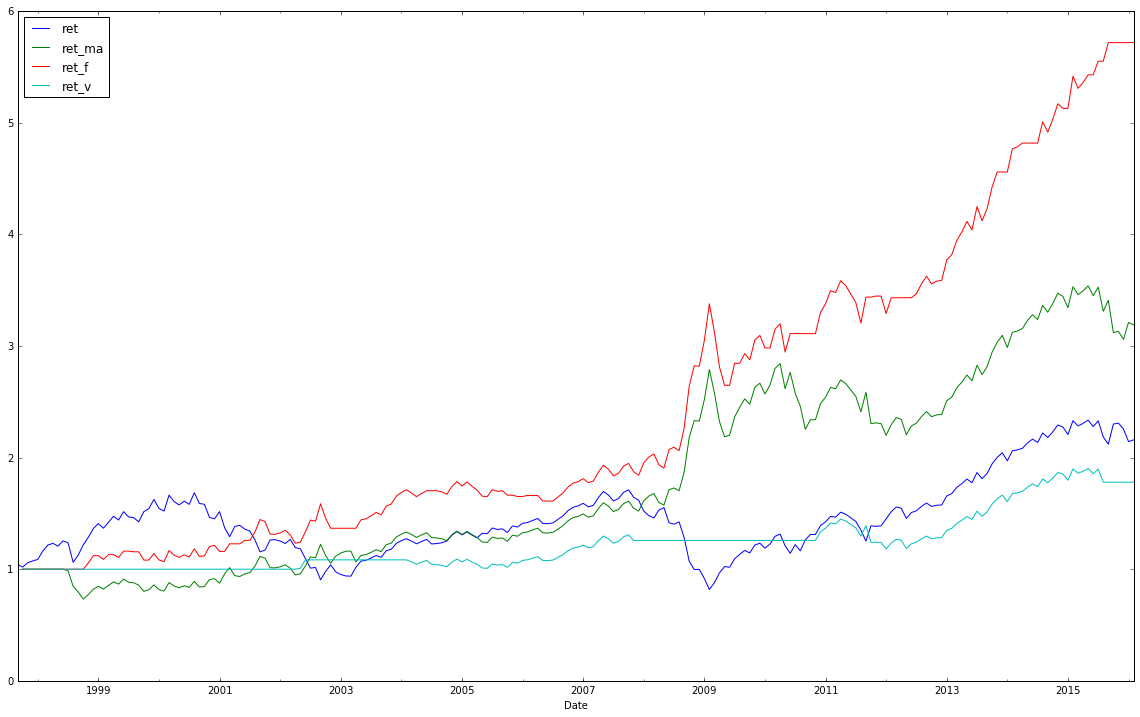

In [522]:
data['ret_ma'] = data['ret'] * data['pos'].shift(1)
data['ret_f'] = data['ret'] * data['pos_f'].shift(1)
data['ret_v'] = data['ret'] * data['pos_v'].shift(1)
(1+data[['ret', 'ret_ma', 'ret_f', 'ret_v']]).cumprod().plot(figsize=[20,12])


In [482]:
data.head()

,price,delta,ret,MA,mmi_delta,mmi_ret,mmi,buy,sell,f_buy,f_sell,vol,pos,pos_f,pos_v,ret_ma,ret_f,ret_v
Date,,,,,,,,,,,,,,,,,,
1997-09-30,94.38,4.00,0.044258,NaN,NaN,NaN,NaN,False,False,0,0,NaN,0,0,0,NaN,NaN,NaN
1997-10-31,92.06,-2.32,-0.024581,NaN,NaN,NaN,NaN,False,False,0,0,NaN,0,0,0,-0,-0,-0
1997-11-30,95.62,3.56,0.038670,NaN,NaN,NaN,NaN,False,False,0,0,NaN,0,0,0,0,0,0
1997-12-31,97.06,1.44,0.015060,NaN,NaN,NaN,NaN,False,False,0,0,NaN,0,0,0,0,0,0
1998-01-31,98.31,1.25,0.012879,NaN,NaN,NaN,NaN,False,False,0,0,NaN,0,0,0,0,0,0
